# Multilabel Classification - Transfer Learning - ResNet18

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset dan Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [4]:
bs = 128
crop_size = 224 #harus sama dgn pre-train (transfer learning)

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/data/train_label.csv", "data/data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = MultilabelDataset("data/data/test_label.csv","data/data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [46]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

## Arsitektur dan Config

In [5]:
from torchvision.models import resnet18

In [6]:
# resnet = resnet18(pretrained=True) #download weight dari resnet18
# #ubah dan reset fully connectednya saja (fc)
# resnet.fc = nn.Sequential(
#             nn.Linear(resnet.fc.in_features, 5),
#             nn.Sigmoid()
# )

#frezee weight dan arsitekturnya
# for param in resnet.parameters():
#     param.requires_grad = False

In [7]:
class CustomResnet18(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        
        self.resnet = resnet18(pretrained=True) #download weight dari resnet18
        self.freeze()
        #ubah dan reset fully connectednya saja (fc)
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.resnet(x)
               
    def freeze(self):
        #frezee weight dan arsitekturnya
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self):
        #unfreeze weight dan arsitekturnya
        for param in self.parameters():
            param.requires_grad = True
            
        

In [8]:
config = set_config ({
    
    "output_size" : 5,
    "batch_size" : bs,
    "crop_size" : crop_size
      
})

## Training Preparation (MCOC) and Training 

### Phase 1 : Adaptation (Learning rate standard + patience kecil)

In [9]:
model = CustomResnet18(config.output_size) 
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="resnet", early_stop_patience=2)

In [10]:
model

CustomResnet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [42]:
from tqdm import tqdm



Epoch     1
Train_cost  = 0.5708 | Test_cost  = 0.5072 | 




Epoch     2
Train_cost  = 0.4810 | Test_cost  = 0.4287 | 




Epoch     3
Train_cost  = 0.4223 | Test_cost  = 0.3796 | 




Epoch     4
Train_cost  = 0.3839 | Test_cost  = 0.3414 | 




Epoch     5
Train_cost  = 0.3594 | Test_cost  = 0.3225 | 




Epoch     6
Train_cost  = 0.3388 | Test_cost  = 0.2984 | 




Epoch     7
Train_cost  = 0.3238 | Test_cost  = 0.2859 | 




Epoch     8
Train_cost  = 0.3091 | Test_cost  = 0.2776 | 




Epoch     9
Train_cost  = 0.2994 | Test_cost  = 0.2663 | 




Epoch    10
Train_cost  = 0.2971 | Test_cost  = 0.2607 | 




Epoch    11
Train_cost  = 0.2943 | Test_cost  = 0.2520 | 




Epoch    12
Train_cost  = 0.2778 | Test_cost  = 0.2474 | 




Epoch    13
Train_cost  = 0.2764 | Test_cost  = 0.2414 | 




Epoch    14
Train_cost  = 0.2685 | Test_cost  = 0.2370 | 




Epoch    15
Train_cost  = 0.2661 | Test_cost  = 0.2327 | 




Epoch    16
Train_cost  = 0.2666 | Test_cost  = 0.2350 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2327




Epoch    17
Train_cost  = 0.2607 | Test_cost  = 0.2297 | 




Epoch    18
Train_cost  = 0.2566 | Test_cost  = 0.2231 | 




Epoch    19
Train_cost  = 0.2598 | Test_cost  = 0.2251 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2231




Epoch    20
Train_cost  = 0.2499 | Test_cost  = 0.2222 | 


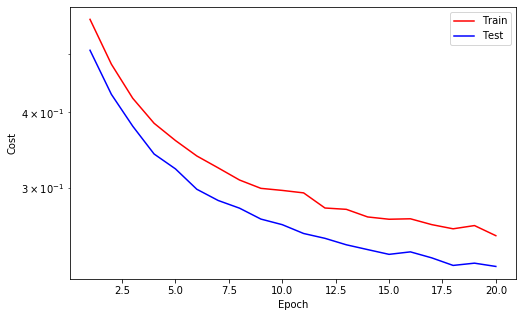



Epoch    21
Train_cost  = 0.2528 | Test_cost  = 0.2185 | 




Epoch    22
Train_cost  = 0.2553 | Test_cost  = 0.2202 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2185




Epoch    23
Train_cost  = 0.2460 | Test_cost  = 0.2161 | 




Epoch    24
Train_cost  = 0.2502 | Test_cost  = 0.2183 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2161




Epoch    25
Train_cost  = 0.2481 | Test_cost  = 0.2198 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2161
==> Execute Early Stopping at epoch: 25 | Best test_cost: 0.2161
==> Best model is saved at resnet


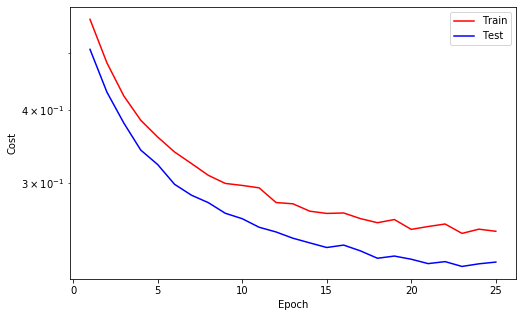

In [38]:
while True:
    model.train()
    cost = 0
    
    for images, labels in tqdm(trainloader, desc=" << Training >> "):
            images, labels = images.to(device), labels.to(device)
        
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            cost += loss.item()*images.shape[0]
    train_cost = cost/len(train_set)
    
    with torch.no_grad():
        model.eval()
        cost = 0
        for images, labels in tqdm(testloader, desc=" << Testing >> "):
            images, labels = images.to(device), labels.to(device)
        
            output = model(images)
            loss = criterion(output, labels)
            
            cost += loss.item()*images.shape[0]
        test_cost = cost/len(test_set)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

### Phase 2 : Fine-tuning (learning rate kecil dan patience standard

In [49]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
callback.early_stop_patience=5

In [ ]:
while True:
    model.train()
    cost = 0
    
    for images, labels in tqdm(trainloader, desc=" << Training >> "):
            images, labels = images.to(device), labels.to(device)
        
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            cost += loss.item()*images.shape[0]
    train_cost = cost/len(train_set)
    
    with torch.no_grad():
        model.eval()
        cost = 0
        for images, labels in tqdm(testloader, desc=" << Testing >> "):
            images, labels = images.to(device), labels.to(device)
        
            output = model(images)
            loss = criterion(output, labels)
            
            cost += loss.item()*images.shape[0]
        test_cost = cost/len(test_set)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break


 << Training >> :   0%|                                                                         | 0/13 [00:00<?, ?it/s]